## 根據台電歷史資料，預測 2019-04-02 至 2019-04-08 的電力尖峰負載(MW)。
### 作業說明：[Peak Load Forecasting](https://hackmd.io/APjYJ2KtQ6CPI0MMUyjmjA?view)

### 一開始想法
以每個星期爲單位，找到一條最適合表示一星期內變化的特徵，並根據整體趨勢決定這條曲線在下一週的高度，最後再看假期要怎麼減。

### Google search

搜索主流的時序預測模型時主要找到 [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) ([statsmodels](https://pypi.org/project/statsmodels/)) 及 2017 年 Facebook 開發的 [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api)，  
Medium 上也有分析兩者差異的[文章](https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851)，在作者的實驗中 ARIMA 模型預測結果較優，  
但基於 Prophet 的新手友善、容易加入 domain knowledge（如從歷史用量看來，假期的電力尖峰負載較小）以及感覺跟一開始的想法比較像，選擇了 **Prophet**。

In [1]:
%matplotlib inline
import pandas as pd

### 讀入資料

In [2]:
df = pd.read_csv('data.csv')
holidays = pd.read_csv('holidays.csv')

#### 台電資料（最舊與最新各 5 筆）

In [3]:
df.head().append(df.tail())

,日期,淨尖峰供電能力(MW),尖峰負載(MW),備轉容量(MW),備轉容量率(%),工業用電(百萬度),民生用電(百萬度),核一#1(萬瓩),核一#2(萬瓩),核二#1(萬瓩),...,大觀二,明潭,碧海,立霧,龍澗,卓蘭,水里,其他小水力,風力發電,太陽能發電
0,20170101,24957.0,22886,2071.0,9.05,268.503,196.229,0.0,62.8,0.0,...,28.6,65.9,0.0,0.0,0.6,2.0,0.0,6.2,12.2,0.0
1,20170102,26035.0,24483,1552.0,6.34,280.534,205.022,0.0,62.8,0.0,...,49.3,94.0,0.0,0.0,0.7,2.2,0.0,6.0,12.7,0.0
2,20170103,29152.0,28131,1021.0,3.63,320.449,234.193,0.0,62.7,0.0,...,39.5,68.3,0.0,0.0,0.4,3.9,0.0,4.0,25.2,0.0
3,20170104,29757.0,28485,1272.0,4.47,329.623,240.898,0.0,62.8,0.0,...,40.9,68.3,0.0,0.0,0.4,3.1,0.0,15.9,9.3,0.0
4,20170105,30065.0,28336,1729.0,6.10,330.137,241.273,0.0,62.8,0.0,...,26.3,61.5,0.0,0.0,0.3,2.1,0.0,9.3,6.5,0.0
816,20190328,NaN,30093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
817,20190329,NaN,29673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818,20190330,NaN,25810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
819,20190331,NaN,24466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
820,20190401,NaN,27760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 截取需要的資料

In [4]:
cols = {'日期':'ds', '尖峰負載(MW)':'y'}
df = df.rename(columns=cols)[cols.values()]
df['ds'] = df['ds'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df.head()

,ds,y
0,2017-01-01,22886
1,2017-01-02,24483
2,2017-01-03,28131
3,2017-01-04,28485
4,2017-01-05,28336


### 2017 年每日尖峰負載

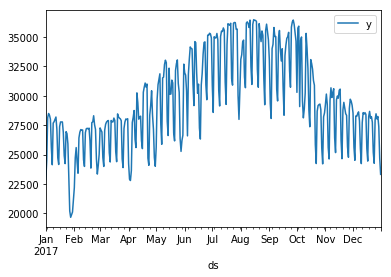

In [5]:
df[df['ds'].dt.year == 2017].plot(x='ds')

### 2018 年每日尖峰負載

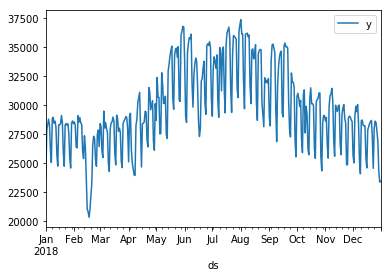

In [6]:
df[df['ds'].dt.year == 2018].plot(x='ds')

### 建模與訓練
將 holidays 做例外處理，並記錄 holidays 時用電量下降的幅度

In [7]:
from fbprophet import Prophet

m = Prophet(holidays=holidays)
m.fit(df)

/home/siahuat0727/.local/share/virtualenvs/taipower-prophet-BkoUF5_J/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 預測

In [8]:
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

### 顯示預測結果

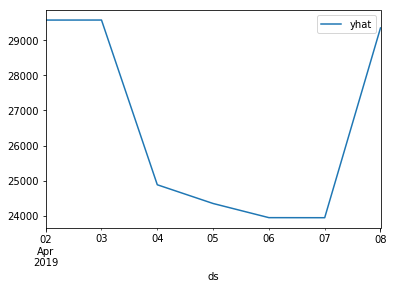

In [9]:
forecast.set_index('ds')['2019-04-02': '2019-04-08'].plot(y='yhat')

## 分析

視覺化每星期、每年的用電量特徵 以及 假期的用電量減少幅度等

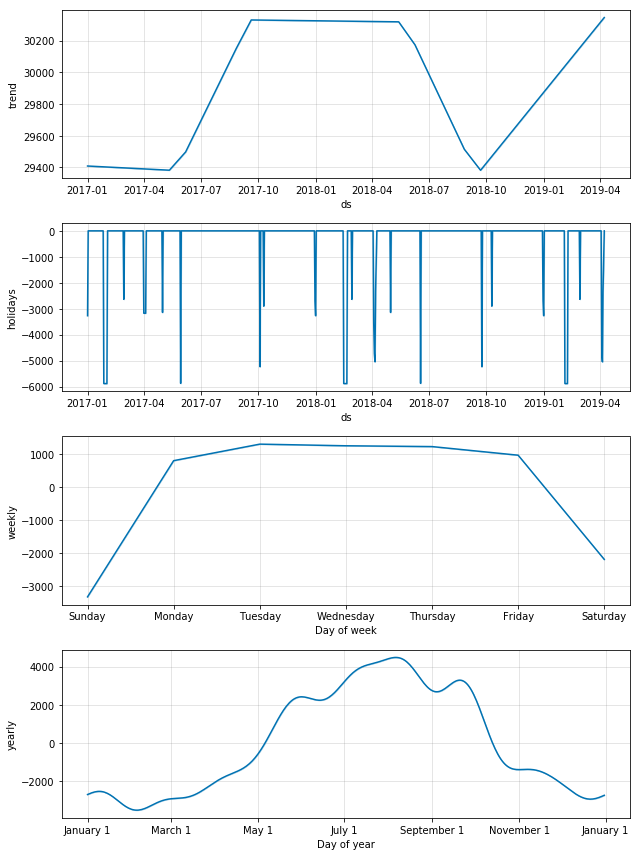

In [10]:
_ = m.plot_components(forecast)

整體上看起來感覺蠻順眼的嗯

/home/siahuat0727/.local/share/virtualenvs/taipower-prophet-BkoUF5_J/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


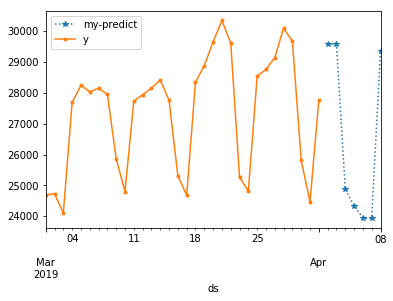

In [11]:
predict = df.set_index('ds')['2019-03-01': '2019-04-01'].append(
    forecast.set_index('ds')['2019-04-02': '2019-04-08'][['yhat']].rename(columns={'yhat':'my-predict'}))
predict.plot(style=['*:', '.-'])

比台電提供的預測值相比，基本上整體變動的幅度偏大，嗯。。。目測感覺台電的比較合理，但可能連假前要加班用電量會比較多對吧(?)

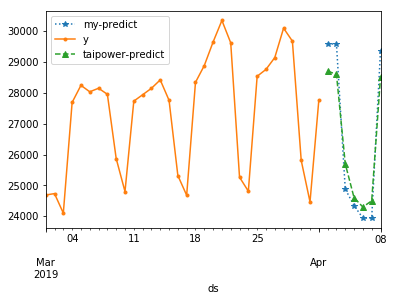

In [12]:
tai_predict = pd.read_csv('tai-predict.csv')
cols = {'日期(年/月/日)': 'ds', '預估瞬時尖峰負載(萬瓩)': 'y'}
tai_predict = tai_predict.rename(columns=cols)[cols.values()]
tai_predict['ds'] = tai_predict['ds'].apply(lambda x: pd.to_datetime(x, format='%Y/%m/%d'))

predict['taipower-predict'] = tai_predict.set_index('ds')[['y']].apply(lambda x: x*10)
predict.plot(style=['*:', '.-', '^--'])

## 關於 holidays.csv

其實在裡面加了一些不知道是加分還是減分的 trick，就是加入 holidays 時，模型看起來預設會把同一類（名字相同）的假期所造成的影響視爲一致的，但根據兩年資料的觀察，同樣是連假，平日的用電減少量會比週末的用電減少量來得多（週末用電量本來就較少，減少的幅度較小）。   

因此特地在剛好落在欲預測之時間範圍的 Spring Break 標上表示星期的數字，讓每天的減少量獨立。而同樣有標星期的只有 2018 年的春假，這是因爲 2018 年的春假是以週末作爲結束的，跟今年比較相似，時間點也比較靠近，感覺比較有參考價值？所以就是直接參考去年春假用電量下降的幅度作爲這次春假預測的依據。  

In [13]:
holidays

,ds,holiday
0,2017-01-01,New Year's Day
1,2017-01-27,Chinese New Year Holiday
2,2017-01-28,Chinese New Year Holiday
3,2017-01-29,Chinese New Year Holiday
4,2017-01-30,Chinese New Year Holiday
5,2017-01-31,Chinese New Year Holiday
6,2017-02-01,Chinese New Year Holiday
7,2017-02-28,228 Peace Memorial Day
8,2017-04-01,Spring Break
9,2017-04-02,Spring Break
